In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import inv

In [2]:
plt.rcParams['figure.figsize'] = [10, 3]

# Q4 - A first Gibbs sampler

## Point 1

In [3]:
# Sample from distribution p(s1,s2|t,y) 
def sample_s(x_b, mu_a, A, b, sigma_a, sigma_ba):
    
    # Calculate Sigma_{a|b}
    sigma_ab = inv(inv(sigma_a) + A.T@inv(sigma_ba)@A)
    
    # Calculate mu_{a|b}
    mu_ab = sigma_ab@(inv(sigma_a)@mu_a + A.T@inv(sigma_ba)@(x_b-b))
    
    # Return N(mu_{a|b}, Sigma_{a|b})
    return multivariate_normal.rvs(mu_ab.reshape(-1), sigma_ab)

# Sample from distribution p(t|s1,s2,y). 
def sample_t(y, s1, s2, sigma_ba):
    
    mean = s1 - s2
    
    # Do moment-matching
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0
    
    # Scale a, b
    a_scaled, b_scaled = (a - mean) / np.sqrt(sigma_ba), (b - mean) / np.sqrt(sigma_ba)
    
    # Return truncated norm (result from Q3 - 2)
    return truncnorm.rvs(a_scaled, b_scaled, mean, sigma_ba)

# Gibbs sampler
def gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init):
    s1_samples = np.zeros(n_samples)
    s2_samples = np.zeros(n_samples)
    s1_samples[0] = s_init[0]
    s2_samples[0] = s_init[1]
    for i in range(1, n_samples):
        t = sample_t(y, s1_samples[i-1], s2_samples[i-1], sigma_ba)
        s1_samples[i], s2_samples[i] = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)
    return s1_samples[burn:], s2_samples[burn:]

In [4]:
# Set values
mu_a = np.array([[0, 0]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
y = 1

In [5]:
def vsPlot(p1, title1, p2, title2):
    plt.figure(1)
    plt.subplot(1, 2, 1)
    plt.plot(p1,label=title1, linewidth=0.75, color='blue')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(p2,label=title2, linewidth=0.75, color='red')
    plt.legend()
    plt.show()

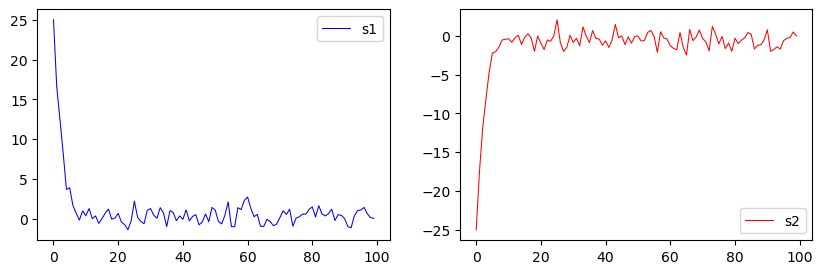

1.0578643932797829
-1.2298026622665037


<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.04

In [6]:
n_samples = 100
burn = 0
s_init = [25,-25]
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
s3, s4 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

vsPlot(s1, 's1', s2, 's2')


print(np.mean(s1))
print(np.mean(s2))
az.rhat(az.convert_to_dataset(np.array([s1, s3])))

## Looking at graph, choose burn-in around 10

### Confirm burn-in performance with Rubin-Gelman statistics

In [7]:
az.rhat(az.convert_to_dataset(np.array([s1[10:], s3[10:]])))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.005

## Point 2

In [8]:
n_samples = 1000
burn = 10
s_init = [0,0]
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

In [9]:
# Take samples from gibbs sampler and transform into gaussian distributions
def gauss_transform(samples, xs):
    s_mean = np.mean(samples)
    s_cov = np.cov(samples)
    gaussian = multivariate_normal.pdf(xs, s_mean, s_cov, n_samples)
    return gaussian

## Point 3 & 4

In [10]:
from time import time
plt.rcParams['figure.figsize'] = [10, 5]

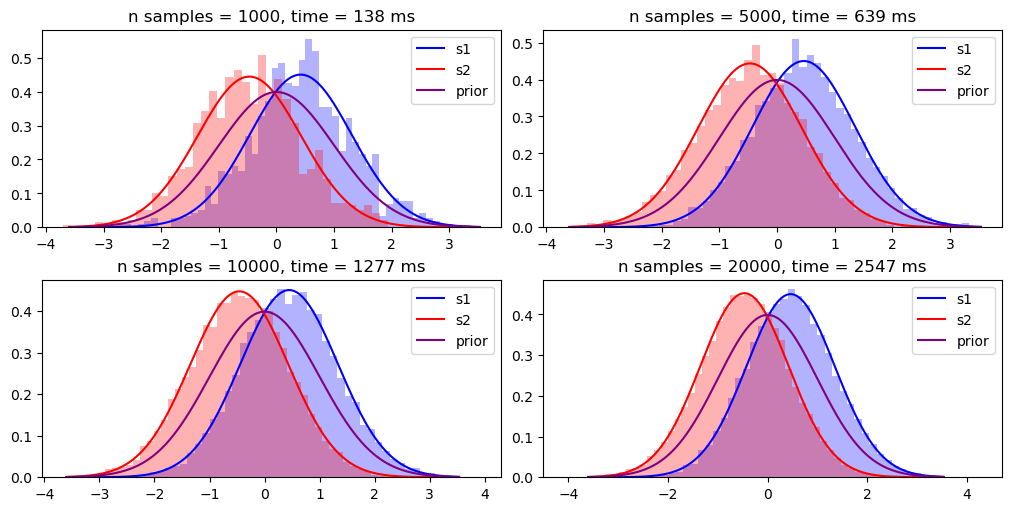

In [11]:
plt.rcParams['figure.constrained_layout.use'] = True

# Function for running tests for point 3. Include prior for point 4 as well
def point3(n, t0, xs):
    s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n, burn, s_init)
    s1_gauss = gauss_transform(s1, xs)
    s2_gauss = gauss_transform(s2, xs)
    t = int((time() - t0)*1000)
    prior = multivariate_normal.pdf(xs, 0, 1, n)
    plt.hist(s1, bins=50, density=True, color='blue', alpha=0.3)
    plt.hist(s2, bins=50, density=True, color='red', alpha=0.3)
    plt.plot(xs, s1_gauss, label='s1', color='blue')
    plt.plot(xs, s2_gauss, label='s2', color='red')
    plt.plot(xs, prior, label='prior', color='purple')
    plt.legend()
    plt.title(f'n samples = {str(n)}, time = {str(t)} ms')


# First run, n = 1000
t0 = time()
n_samples = 1000
xs = np.linspace(np.mean(s1)-4, np.mean(s2)+4, n_samples)
plt.subplot(2,2,1)
point3(n_samples, t0, xs)

# Second run, n = 5000
t0 = time()
n_samples = 5000
plt.subplot(2,2,2)
point3(n_samples, t0, xs)

# Third run, n = 10000
t0 = time()
n_samples = 10000
plt.subplot(2,2,3)
point3(n_samples, t0, xs)

# Fourth run, n = 20000
t0 = time()
n_samples = 20000
plt.subplot(2,2,4)
point3(n_samples, t0, xs)


plt.show()

# Q5 - Assumed Density Filtering

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('SerieA.csv')
df.head()

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2
0,2018-08-18,18:00,Chievo,Juventus,2,3
1,2018-08-18,20:30,Lazio,Napoli,1,2
2,2018-08-19,18:00,Torino,Roma,0,1
3,2018-08-19,20:30,Sassuolo,Inter,1,0
4,2018-08-19,20:30,Parma,Udinese,2,2


In [14]:
def ADF(df, n_samples):
    
    # Extract unique teams
    teams = df['team1'].drop_duplicates() 
    
    # Initialize every team with initial skill parameters [mean=0, var=1] (Could induce better prior knowledge here)
    skill_list = dict.fromkeys(teams, [0,1]) 
    
    for i in range(len(df)):
    
        # Check if either team won, ignore draws
        if (df.iloc[i]['score1'] > df.iloc[i]['score2']):
            winner = df.iloc[i]['team1']
            loser = df.iloc[i]['team2']
        elif (df.iloc[i]['score1'] < df.iloc[i]['score2']):
            winner = df.iloc[i]['team2']
            loser = df.iloc[i]['team1']
        else:
            continue # Skip ties

        # New sample with current skills as prior
        mu_a = np.array([[skill_list[winner][0], skill_list[loser][0]]]).T
        sigma_a = np.array([[skill_list[winner][1],0],[0,skill_list[loser][1]]])
        s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

        # Update parameters
        skill_list[winner] = [np.mean(s1), np.var(s1)]
        skill_list[loser] = [np.mean(s2), np.var(s2)]
    
    return skill_list

In [15]:
skill_list = ADF(df, n_samples=1000)
rankings = pd.DataFrame.from_dict(skill_list, orient='index', columns=['mean', 'variance'])
rankings.sort_values(by=['mean'], ascending=False)

,mean,variance
Juventus,1.106491,0.119068
Napoli,0.859642,0.092979
Milan,0.663039,0.092000
Atalanta,0.579737,0.076443
Inter,0.556437,0.081186
Torino,0.543479,0.077365
Roma,0.445844,0.076168
Lazio,0.303760,0.062665
Sampdoria,0.057480,0.056462
Udinese,-0.158805,0.083306


### Try with shuffled games

In [16]:
shuffledDF = df.sample(frac=1).reset_index(drop=True)
skill_list = ADF(shuffledDF, n_samples=1000)
rankings = pd.DataFrame.from_dict(skill_list, orient='index', columns=['mean', 'variance'])
rankings.sort_values(by=['mean'], ascending=False)

,mean,variance
Juventus,1.198624,0.109931
Napoli,0.773722,0.068062
Milan,0.563674,0.071922
Roma,0.524035,0.084982
Inter,0.476037,0.076950
Torino,0.460166,0.098997
Atalanta,0.377040,0.073910
Lazio,0.217931,0.080446
Sampdoria,0.164337,0.072511
Bologna,-0.098010,0.093778


# Q6 - Using the model for predictions

In [17]:
def predict(df, n_samples):
    
    # Extract unique teams
    teams = df['team1'].drop_duplicates() 
    
    # Initialize every team with initial skill parameters [mean=0, var=1] (Could induce better prior knowledge here)
    skill_list = dict.fromkeys(teams, [0,1]) 
    
    correct_predictions = 0
    total_predictions = 0
    
    for i in range(len(df)):
    
        # Check if either team won, ignore draws
        if (df.iloc[i]['score1'] > df.iloc[i]['score2']):
            winner = df.iloc[i]['team1']
            loser = df.iloc[i]['team2']
        elif (df.iloc[i]['score1'] < df.iloc[i]['score2']):
            winner = df.iloc[i]['team2']
            loser = df.iloc[i]['team1']
        else:
            continue # Skip ties
            
        if (skill_list[winner][0] > skill_list[loser][0]):
            correct_predictions += 1
        total_predictions += 1

        mu_a = np.array([[skill_list[winner][0], skill_list[loser][0]]]).T
        sigma_a = np.array([[skill_list[winner][1],0],[0,skill_list[loser][1]]])

        s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

        skill_list[winner] = [np.mean(s1), np.var(s1)]
        skill_list[loser] = [np.mean(s2), np.var(s2)]
    
    return correct_predictions/total_predictions

In [18]:
predict(df, n_samples=1000)

0.6433823529411765